In [1]:
#Requirements for the project:

In [2]:
#required libraries for this project:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import string
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout

In [3]:
#resources of nltk
nltk.download('punkt_tab')
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4') 

[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\shive\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\shive\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\shive\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\shive\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\shive\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [4]:
#Data Exploration for the project:

In [5]:
#loading the dataset 
fake_news = pd.read_csv(r'C:\Users\shive\compiler_code\new2\Fake.csv')
real_news = pd.read_csv(r'C:\Users\shive\compiler_code\new2\True.csv')

In [6]:
#showing the sample of both the dataset:
print(fake_news.head())
print(real_news.head())

                                               title  \
0   Donald Trump Sends Out Embarrassing New Year’...   
1   Drunk Bragging Trump Staffer Started Russian ...   
2   Sheriff David Clarke Becomes An Internet Joke...   
3   Trump Is So Obsessed He Even Has Obama’s Name...   
4   Pope Francis Just Called Out Donald Trump Dur...   

                                                text subject  \
0  Donald Trump just couldn t wish all Americans ...    News   
1  House Intelligence Committee Chairman Devin Nu...    News   
2  On Friday, it was revealed that former Milwauk...    News   
3  On Christmas day, Donald Trump announced that ...    News   
4  Pope Francis used his annual Christmas Day mes...    News   

                date  
0  December 31, 2017  
1  December 31, 2017  
2  December 30, 2017  
3  December 29, 2017  
4  December 25, 2017  
                                               title  \
0  As U.S. budget fight looms, Republicans flip t...   
1  U.S. military to accept t

In [7]:
#set in form as bit for the real as well as fake news
real_news['label'] = 1
fake_news['label'] = 0

In [8]:
#showing the basic information about the dataset:
print("Real news dataset shape:", real_news.shape)
print("Fake news dataset shape:", fake_news.shape)

Real news dataset shape: (21417, 5)
Fake news dataset shape: (23481, 5)


In [9]:
#mergint the two sets of the data assuming that both are having the same structure:
news_df = pd.concat([real_news, fake_news], axis=0)
news_df = news_df.reset_index(drop=True)

In [10]:
#showing the random data:
print("\nSample data:")
print(news_df.head())


Sample data:
                                               title  \
0  As U.S. budget fight looms, Republicans flip t...   
1  U.S. military to accept transgender recruits o...   
2  Senior U.S. Republican senator: 'Let Mr. Muell...   
3  FBI Russia probe helped by Australian diplomat...   
4  Trump wants Postal Service to charge 'much mor...   

                                                text       subject  \
0  WASHINGTON (Reuters) - The head of a conservat...  politicsNews   
1  WASHINGTON (Reuters) - Transgender people will...  politicsNews   
2  WASHINGTON (Reuters) - The special counsel inv...  politicsNews   
3  WASHINGTON (Reuters) - Trump campaign adviser ...  politicsNews   
4  SEATTLE/WASHINGTON (Reuters) - President Donal...  politicsNews   

                 date  label  
0  December 31, 2017       1  
1  December 29, 2017       1  
2  December 31, 2017       1  
3  December 30, 2017       1  
4  December 29, 2017       1  


In [11]:
#checking for the missing data:
print("\nMissing values per column:")
print(news_df.isnull().sum())


Missing values per column:
title      0
text       0
subject    0
date       0
label      0
dtype: int64


In [12]:
#showing the complete stats of the data:
print("\nLabel distribution:")
print(news_df['label'].value_counts())


Label distribution:
label
0    23481
1    21417
Name: count, dtype: int64


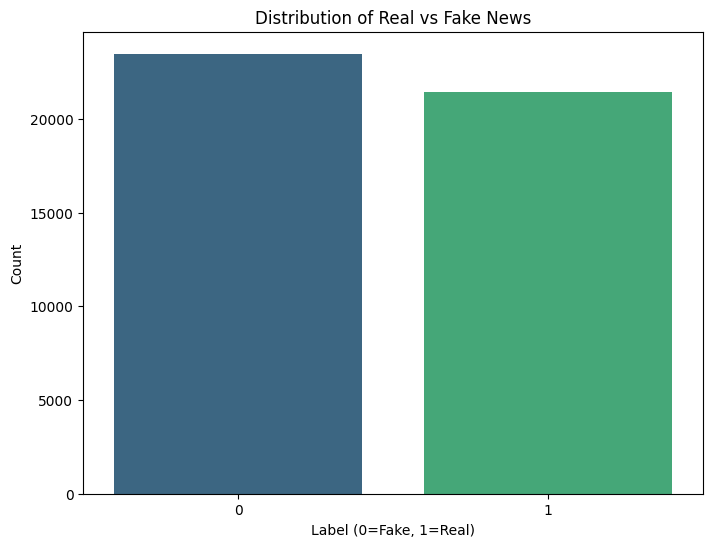

In [13]:
#showing in the form of the visual format:
plt.figure(figsize=(8, 6))
sns.countplot(x='label', hue='label', data=news_df, palette='viridis', legend=False)
plt.title('Distribution of Real vs Fake News')
plt.xlabel('Label (0=Fake, 1=Real)')
plt.ylabel('Count')
plt.show()

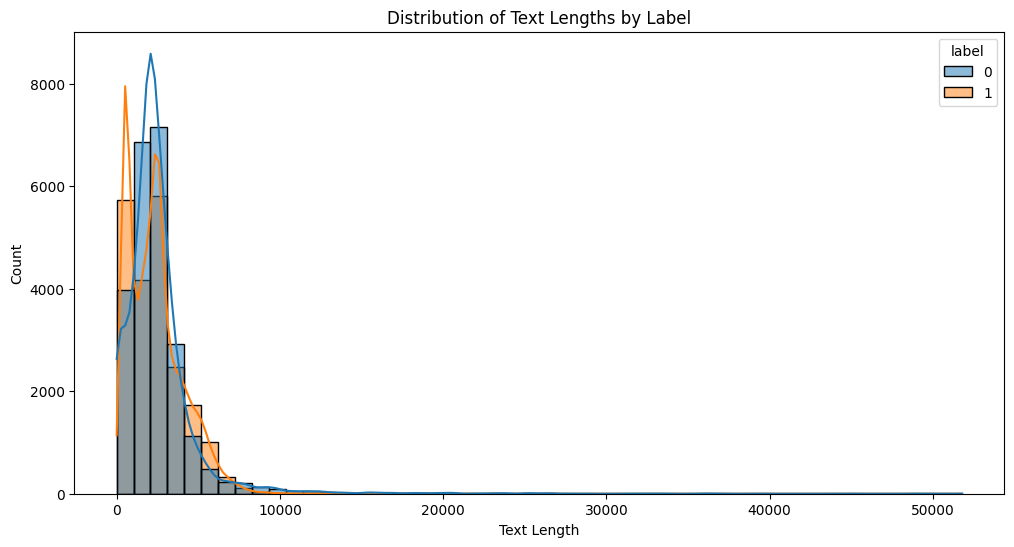

In [14]:
#calculating the length of the text for both from of the data:
news_df['text_length'] = news_df['text'].apply(len)
plt.figure(figsize=(12, 6))
sns.histplot(data=news_df, x='text_length', hue='label', bins=50, kde=True)
plt.title('Distribution of Text Lengths by Label')
plt.xlabel('Text Length')
plt.show()

In [15]:
#Data preprocessing for the given project:

In [16]:
#function for cleaning the text:
def clean_text(text):
    if isinstance(text, str):
        # Convert to lowercase
        text = text.lower()
        
        # Remove URLs
        text = re.sub(r'http\S+|www\S+|https\S+', '', text)
        
        # Remove HTML tags
        text = re.sub(r'<.*?>', '', text)
        
        # Remove punctuation
        text = text.translate(str.maketrans('', '', string.punctuation))
        
        # Remove extra whitespace
        text = re.sub(r'\s+', ' ', text).strip()
        
        return text
    else:
        return ""

In [17]:
stop_words = set(stopwords.words('english'))

def preprocess(text):
    text = text.lower()  # Lowercase
    text = re.sub(r'\W+', ' ', text)  # Remove punctuation and special chars
    words = text.split()
    words = [word for word in words if word not in stop_words]  # Remove stopwords
    return ' '.join(words)

# Apply preprocessing
news_df['processed_text'] = news_df['text'].apply(preprocess)

In [18]:
def process_text(text):
    try:
        # Ensure text is a string
        if not isinstance(text, str):
            return ""
            
        # Tokenize
        tokens = nltk.word_tokenize(text)
        
        # Remove stopwords
        stop_words = set(stopwords.words('english'))
        tokens = [word for word in tokens if word not in stop_words]
        
        # Lemmatize
        lemmatizer = WordNetLemmatizer()
        tokens = [lemmatizer.lemmatize(word) for word in tokens]
        
        # Join tokens back to text
        processed_text = ' '.join(tokens)
        
        return processed_text
    except Exception as e:
        print(f"Error in process_text: {type(e).__name__}: {e}")
        # Return the original text if processing fails
        return text if isinstance(text, str) else ""

In [19]:
# Apply text cleaning and processing
print("Cleaning and processing text data...")
news_df['clean_text'] = news_df['text'].apply(clean_text)
news_df['processed_text'] = news_df['clean_text'].apply(process_text)

Cleaning and processing text data...


In [20]:
#displaying the text samples:
print("\nSample processed text:")
for i in range(2):
    print(f"Original: {news_df['text'].iloc[i][:100]}...")
    print(f"Processed: {news_df['processed_text'].iloc[i][:100]}...")
    print()


Sample processed text:
Original: WASHINGTON (Reuters) - The head of a conservative Republican faction in the U.S. Congress, who voted...
Processed: washington reuters head conservative republican faction u congress voted month huge expansion nation...

Original: WASHINGTON (Reuters) - Transgender people will be allowed for the first time to enlist in the U.S. m...
Processed: washington reuters transgender people allowed first time enlist u military starting monday ordered f...



In [21]:
#Training and testing the given data

In [22]:
#dividing the cleaned and preprocessed data into two parts for testing(20%) and training(80%)
from sklearn.model_selection import train_test_split

X = news_df['processed_text']
y = news_df['label']

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42  # ensures reproducibility (same shuffle every time)
)
# So your model learns from 80% and is tested on 20% it has never seen before, ensuring it generalizes well.

In [23]:
# Text (like news articles) is unstructured data, and ML models like LogisticRegression or RandomForest need numerical input.
# TfidfVectorizer transforms your processed text into numerical feature vectors using a method called TF-IDF (Term Frequency - Inverse Document Frequency).
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(max_features=5000)
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)


In [24]:
# Train a Logistic Regression model to classify whether a news article is real (1) or fake (0), based on its TF-IDF features.
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# Train
model = LogisticRegression()
model.fit(X_train_tfidf, y_train)

# Predict whether each article in the test is real or fake.
y_pred = model.predict(X_test_tfidf)

# Evaluate the score
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))


Accuracy: 0.9866369710467706
Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.98      0.99      4650
           1       0.98      0.99      0.99      4330

    accuracy                           0.99      8980
   macro avg       0.99      0.99      0.99      8980
weighted avg       0.99      0.99      0.99      8980



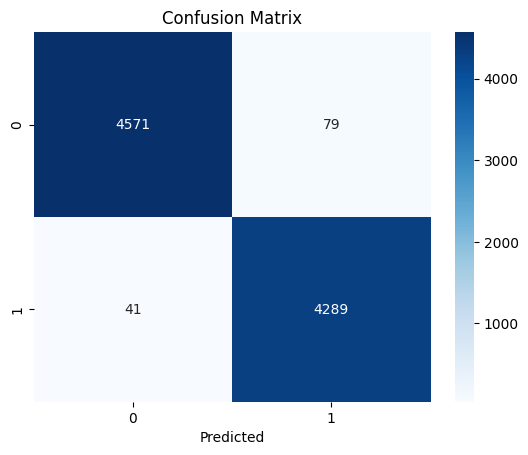

In [25]:
#visualization of the data using confusion matrix and ROC curve to better observation.

# Confusion Matrix
import seaborn as sns
import matplotlib.pyplot as plt
cm = confusion_matrix(y_test, y_pred)
# y_test: Represents the true, actual labels of your test dataset.
# y_pred: Represents the labels predicted by your classification model on the test dataset.

sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
# plt.ylabel("Actual")
plt.show()


In [26]:
# Rows (Actual): These represent the true classes of your data points.

#     0: Actual class 0
#     1: Actual class 1

# Columns (Predicted): These represent the classes predicted by your model.

#     0: Predicted class 0
#     1: Predicted class 1

# The model is performing quite well overall, as the true positive (4289) and true negative (4571)
# counts are significantly higher than the false positive (79) and false negative (41) counts.

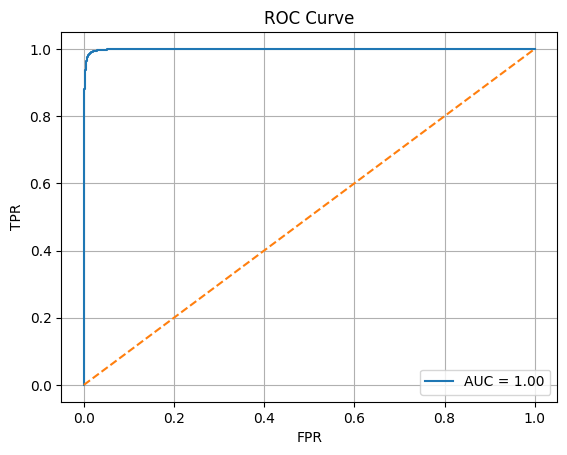

In [27]:
# ROC Curve
from sklearn.metrics import roc_curve, roc_auc_score

# The Receiver Operating Characteristic (ROC) curve is a graphical plot that illustrates the diagnostic ability
# of a binary classifier system as its discrimination threshold is varied. It plots the True Positive Rate (TPR)
# against the False Positive Rate (FPR) at various threshold settings.

y_prob = model.predict_proba(X_test_tfidf)[:, 1]
fpr, tpr, _ = roc_curve(y_test, y_prob)
auc_score = roc_auc_score(y_test, y_prob)

plt.plot(fpr, tpr, label=f"AUC = {auc_score:.2f}")
plt.plot([0, 1], [0, 1], linestyle='--')
plt.title("ROC Curve")
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.legend()  #Displays the legend, which includes the AUC score.
plt.grid(True) #Adds a grid to the plot for better readability.
plt.show()

# a higher AUC score means your model is better at correctly ranking positive instances above negative instances,
# regardless of the specific threshold you choose for classification.
# AUC score stands for Area Under the Receiver Operating Characteristic (ROC) Curve. 

In [28]:
import joblib
joblib.dump(model, 'logistic_model.pkl')
joblib.dump(vectorizer, 'tfidf_vectorizer.pkl')
# These lines of code signify the saving (or "persisting") of trained machine learning objects to disk

['tfidf_vectorizer.pkl']